# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings_Augmented/VGG16_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2    3         4    5    6    7    8    9  \
41001 201546 -0.714023 -1.0 -0.965837 -1.0  0.016764 -1.0 -1.0 -1.0 -1.0 -1.0   
      201547 -0.860413 -1.0 -0.994801 -1.0 -0.405787 -1.0 -1.0 -1.0 -1.0 -1.0   
      201548 -0.860413 -1.0 -0.994801 -1.0 -0.405787 -1.0 -1.0 -1.0 -1.0 -1.0   
      201549 -0.838484 -1.0 -0.993628 -1.0 -0.348286 -1.0 -1.0 -1.0 -1.0 -1.0   
      201550 -0.659738 -1.0 -0.940415 -1.0 -0.329606 -1.0 -1.0 -1.0 -1.0 -1.0   

              ...       503       504       505       506       507  508  509  \
41001 201546  ... -0.781552 -0.946713 -0.918259 -0.977922 -0.234515 -1.0 -1.0   
      201547  ... -0.947044 -0.839812 -0.582354 -0.971883 -0.117142 -1.0 -1.0   
      201548  ... -0.947044 -0.839812 -0.582354 -0.971883 -0.117142 -1.0 -1.0   
      201549  ... -0.940595 -0.911255 -0.712429 -0.987575 -0.163913 -1.0 -1.0   
      201550  ... -0.823214 -0.893076 -0.665254 -0.978527 -0.156049 -1.0 -1.0   

                   510  511    Labels  
41001 201546 -0.652938 -1.0 -0.861740  
      201547 -0.431755 -1.0 -0.854589  
      201548 -0.431755 -1.0 -0.856973  
      201549 -0.509990 -1.0 -0.856973  
      201550 -0.529192 -1.0 -0.823600  

[5 rows x 513 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0    1         2         3         4    5         6  \
41001 201820 -0.965470 -1.0 -0.994532 -0.851932 -0.273365 -1.0 -1.000000   
      201821 -0.678473 -1.0 -0.846597 -1.000000 -0.127577 -1.0 -0.950266   
      201822 -0.736059 -1.0 -0.796439 -0.635764 -0.092963 -1.0 -0.960502   
      201823 -0.753718 -1.0 -0.672318 -0.689572  0.206642 -1.0 -1.000000   
      201824 -0.778036 -1.0 -0.996226 -0.995550 -0.446913 -1.0 -1.000000   

                     7         8         9  ...       503       504       505  \
41001 201820 -1.000000 -1.000000 -1.000000  ... -0.312907 -0.600099 -0.968903   
      201821 -0.942133 -1.000000 -0.962788  ... -0.931556 -0.632124 -0.704086   
      201822 -1.000000 -1.000000 -1.000000  ... -0.870119 -0.582624 -0.742784   
      201823 -0.938184 -0.764103 -1.000000  ...  0.308456 -0.021049 -0.961482   
      201824 -1.000000 -1.000000 -1.000000  ... -0.788230 -0.702541 -0.638802   

                   506       507  508       509       510  511    Labels  
41001 201820 -0.906695 -0.029838 -1.0 -1.000000 -0.641944 -1.0 -0.949940  
      201821 -0.987561  0.197870 -1.0 -1.000000 -0.445259 -1.0 -0.961859  
      201822 -0.952094  0.070667 -1.0 -1.000000 -0.527596 -1.0 -0.940405  
      201823 -0.767787 -0.357560 -1.0 -0.370403 -0.371539 -1.0 -0.961859  
      201824 -0.905000  0.673927 -1.0 -0.951348 -0.113325 -1.0 -0.954708  

[5 rows x 513 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 513)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 513)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 512)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 512)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

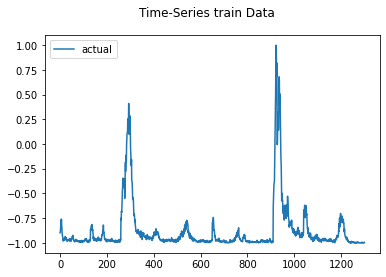

2023-03-13 21:24:06.538500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 21:24:06.538543: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 21:24:06.538565: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-13 21:24:06.538869: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 21:24:06.654541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 40.590
Test RMSE: 50.504
Test sMAPE: 102.876
Test R Squared: -1.639
{'mae': 40.59036425875895, 'rmse': 50.50392936210082, 'smape': 102.87632253733031, 'r2': -1.6393217667268827}


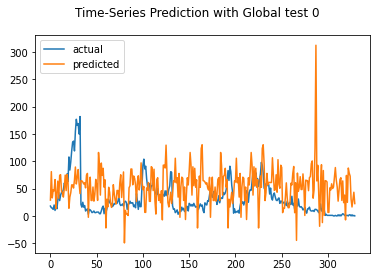

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 43.285
Test RMSE: 53.971
Test sMAPE: 107.667
Test R Squared: -2.014
{'mae': 43.28459203622558, 'rmse': 53.97092852891246, 'smape': 107.66657357044565, 'r2': -2.0141286240980336}


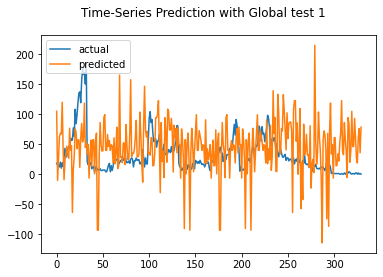

Test MAE: 36.831
Test RMSE: 44.252
Test sMAPE: 94.838
Test R Squared: -1.026
{'mae': 36.83141462586143, 'rmse': 44.25238168152786, 'smape': 94.83818014285703, 'r2': -1.0263539196366982}


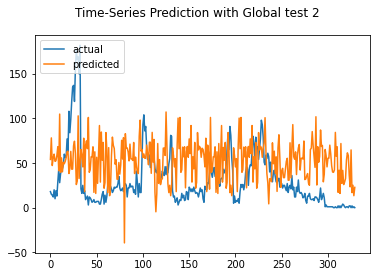

Test MAE: 86.504
Test RMSE: 109.028
Test sMAPE: 125.262
Test R Squared: -11.300
{'mae': 86.50398863301133, 'rmse': 109.0284078819965, 'smape': 125.2619775397346, 'r2': -11.30045969044124}


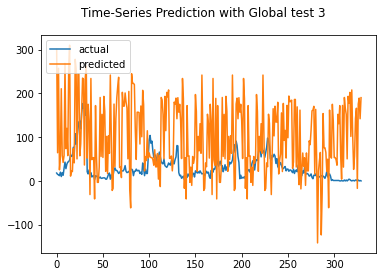

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 43.579
Test RMSE: 55.201
Test sMAPE: 114.676
Test R Squared: -2.153
{'mae': 43.57894939075817, 'rmse': 55.20089868658106, 'smape': 114.67626489134832, 'r2': -2.1530749781142657}


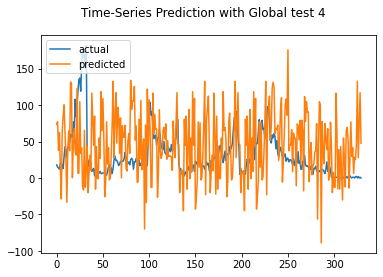

Test MAE: 53.288
Test RMSE: 71.096
Test sMAPE: 123.014
Test R Squared: -4.230
{'mae': 53.288438941131936, 'rmse': 71.0955477077517, 'smape': 123.01433326637039, 'r2': -4.230302533556886}


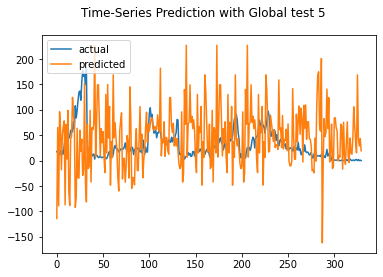

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 38.040
Test RMSE: 48.386
Test sMAPE: 107.460
Test R Squared: -1.423
{'mae': 38.03975436542974, 'rmse': 48.38605505650158, 'smape': 107.4600224320979, 'r2': -1.4226040125101203}


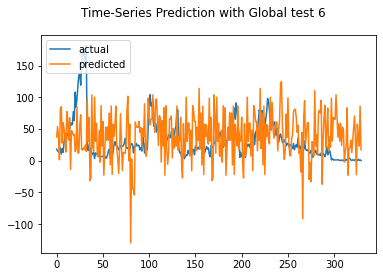

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 42.779
Test RMSE: 55.516
Test sMAPE: 96.451
Test R Squared: -2.189
{'mae': 42.77935856761354, 'rmse': 55.51608577124107, 'smape': 96.45130459929953, 'r2': -2.1891847432317575}


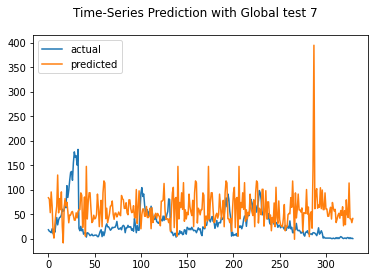

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 45.981
Test RMSE: 68.644
Test sMAPE: 105.442
Test R Squared: -3.876
{'mae': 45.98096655092456, 'rmse': 68.64430042617175, 'smape': 105.44159496669418, 'r2': -3.8758570933982144}


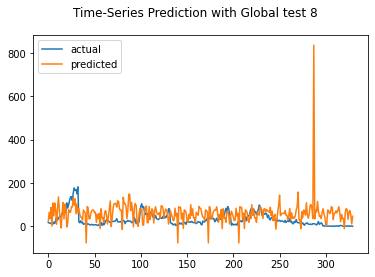

Test MAE: 53.679
Test RMSE: 63.086
Test sMAPE: 107.155
Test R Squared: -3.118
{'mae': 53.679125246857154, 'rmse': 63.08571902410857, 'smape': 107.15511728920055, 'r2': -3.118168537663559}


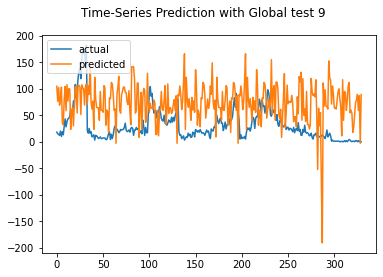

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 44.582
Test RMSE: 56.223
Test sMAPE: 117.217
Test R Squared: -2.271
{'mae': 44.58249726150975, 'rmse': 56.22294428350683, 'smape': 117.21658192387646, 'r2': -2.2709143465695574}


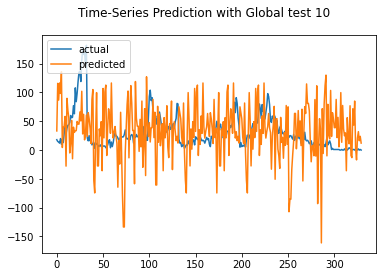

Test MAE: 55.958
Test RMSE: 69.212
Test sMAPE: 104.809
Test R Squared: -3.957
{'mae': 55.95811225717718, 'rmse': 69.21212275251172, 'smape': 104.80939173823324, 'r2': -3.956856431953242}


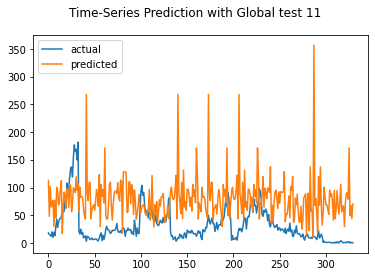

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 35.647
Test RMSE: 44.866
Test sMAPE: 93.934
Test R Squared: -1.083
{'mae': 35.647083992127214, 'rmse': 44.86592368024353, 'smape': 93.9335862747435, 'r2': -1.0829326526581107}


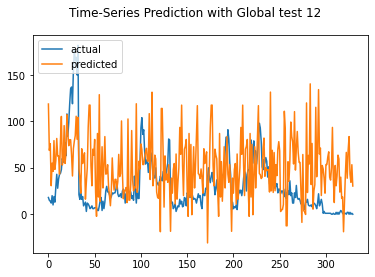

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 38.838
Test RMSE: 50.693
Test sMAPE: 97.957
Test R Squared: -1.659
{'mae': 38.8382018911116, 'rmse': 50.69256067253239, 'smape': 97.95706280335408, 'r2': -1.6590742286326114}


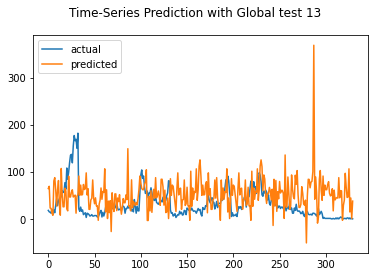

Test MAE: 40.600
Test RMSE: 50.055
Test sMAPE: 106.134
Test R Squared: -1.593
{'mae': 40.60035139602242, 'rmse': 50.05486451318658, 'smape': 106.1335442591963, 'r2': -1.592594420299478}


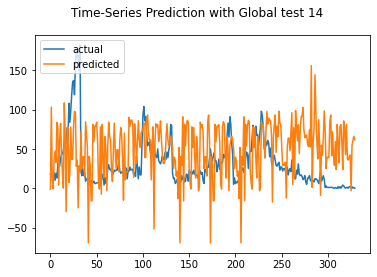

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 38.636
Test RMSE: 59.884
Test sMAPE: 113.493
Test R Squared: -2.711
{'mae': 38.63634889586405, 'rmse': 59.883876218562136, 'smape': 113.49252736251374, 'r2': -2.7107509700172687}


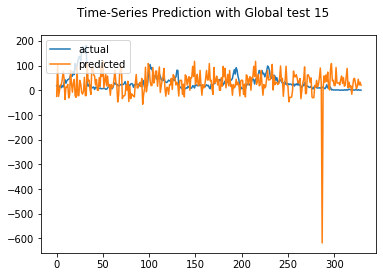

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 44.661
Test RMSE: 60.543
Test sMAPE: 109.558
Test R Squared: -2.793
{'mae': 44.66141074390122, 'rmse': 60.542776116907355, 'smape': 109.55814790697076, 'r2': -2.7928587020068885}


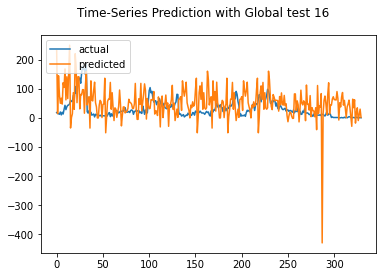

Test MAE: 64.288
Test RMSE: 73.066
Test sMAPE: 125.426
Test R Squared: -4.524
{'mae': 64.2881961402568, 'rmse': 73.06567194710757, 'smape': 125.42589214527843, 'r2': -4.524192029473575}


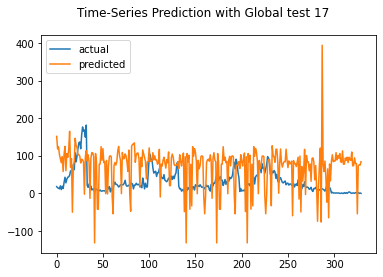

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 33.921
Test RMSE: 40.743
Test sMAPE: 90.441
Test R Squared: -0.718
{'mae': 33.92128447691599, 'rmse': 40.742954999713874, 'smape': 90.44114114382104, 'r2': -0.7176989500306012}


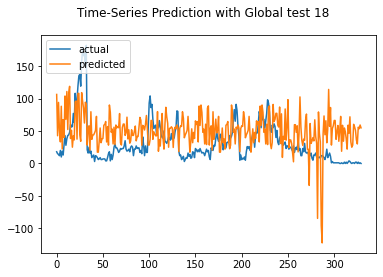

Test MAE: 66.207
Test RMSE: 80.199
Test sMAPE: 111.547
Test R Squared: -5.656
{'mae': 66.20718793598088, 'rmse': 80.19917243378657, 'smape': 111.54695866050648, 'r2': -5.65551666786624}


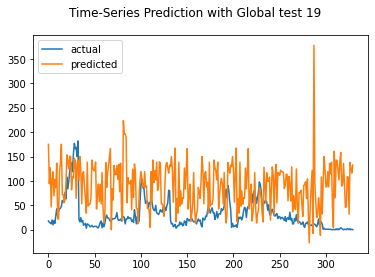

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 36.858
Test RMSE: 49.849
Test sMAPE: 113.185
Test R Squared: -1.571
{'mae': 36.85834130626736, 'rmse': 49.84889366886093, 'smape': 113.18474043197065, 'r2': -1.5713017770957252}


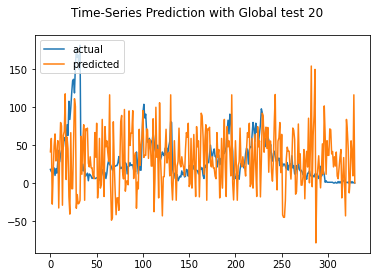

Test MAE: 45.828
Test RMSE: 62.071
Test sMAPE: 100.315
Test R Squared: -2.987
{'mae': 45.82812696731452, 'rmse': 62.070507409169245, 'smape': 100.31459567616147, 'r2': -2.986691158063015}


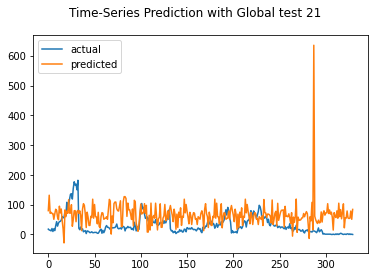

Test MAE: 57.657
Test RMSE: 70.696
Test sMAPE: 130.359
Test R Squared: -4.172
{'mae': 57.65691764426954, 'rmse': 70.6962543390839, 'smape': 130.35918268737476, 'r2': -4.171717697175652}


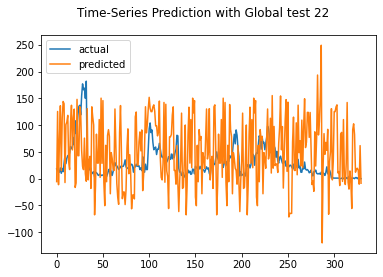

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 46.551
Test RMSE: 57.880
Test sMAPE: 108.661
Test R Squared: -2.467
{'mae': 46.550885662888035, 'rmse': 57.87953350586703, 'smape': 108.66064553052038, 'r2': -2.46650671637023}


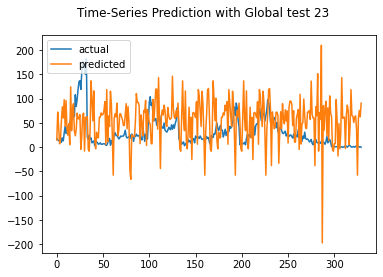

Test MAE: 52.861
Test RMSE: 62.383
Test sMAPE: 109.150
Test R Squared: -3.027
{'mae': 52.86082814570629, 'rmse': 62.38254415920528, 'smape': 109.15004440181629, 'r2': -3.0268751703091583}


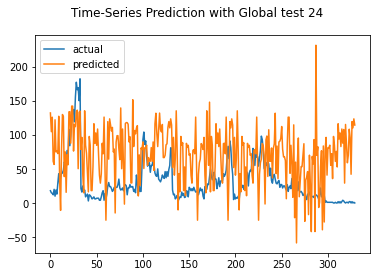

In [ ]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')